## Focal Statistics

In this tutorial we calculate focal statistics and determine hot and cold spots of NDVI (Normalized difference vegetation index) over a time series of satellite images. On its own, NDVI is used to highlight live green vegetation. Its hot and cold spots help determine the growth or loss of plants. In this notebook, we'll see how to:

- Search for satellite data by item ID using `pystac_client`
- Visualize true color images
- Calculate NDVI
- Smooth images with a mean filter
- Calculate focal statistics of the values within a specified focal neighborhood for each pixel in an input data array
- Identify hot and cold spots in a image, neighborhoods that are significantly different from the rest of the image

The focus of this notebook is to analyse information for each pixel based on its focal neighborhood kernel. The [xrspatial.focal](https://xarray-spatial.org/user_guide/focal.html) module from `xarray-spatial` provides a set of analysis tools performing neighborhood operations that will be used through this tutorial.

In [1]:
import numpy as np
import xarray as xr

import stackstac
import planetary_computer
import pystac_client

import matplotlib.pyplot as plt

import xrspatial.multispectral as ms
from xrspatial.convolution import calc_cellsize, circle_kernel, convolution_2d
from xrspatial.focal import mean, focal_stats, hotspots

from dask.distributed import Client, progress

### Local Dask Cluster

We'll use a small number of images for this example. We'll parallelize reading the data from Azure Blob Storage using a local Dask "cluster" on this single machine.

In [2]:
client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

2022-08-16 16:30:24,531 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-l6lzssem', purging
2022-08-16 16:30:24,532 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-h374kdv4', purging
2022-08-16 16:30:24,532 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-isifihn_', purging
2022-08-16 16:30:24,532 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-swbsk4a4', purging


/proxy/8787/status


You can access the Dask Dashboard by pasting that URL into the Dask labextension field. See [Scale with Dask](../quickstarts/scale-with-dask.ipynb) for more.

### Data

The region of interest is a small area in the Amazon rainforest located in State of Mato Grosso and State of Amazonas, Brazil. In order to calculate NDVI accurately, we found these least cloudy scenes by searching with the [STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and filtering the results.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

ids = [
    "S2A_MSIL2A_20200616T141741_R010_T20LQR_20200822T232052",
    "S2B_MSIL2A_20190617T142049_R010_T20LQR_20201006T032921",
    "S2B_MSIL2A_20180712T142039_R010_T20LQR_20201011T150557",
    "S2B_MSIL2A_20170727T142039_R010_T20LQR_20210210T153028",
    "S2A_MSIL2A_20160627T142042_R010_T20LQR_20210211T234456",
]
search = catalog.search(collections=["sentinel-2-l2a"], ids=ids)

Now we'll sign the STAC items so we can download the data from blob storage. See [Using Tokens for Data Access](../concepts/sas.ipynb) for more. 

In [4]:
items = search.item_collection()

data = (
    stackstac.stack(
        items,
        epsg=32619,
        resolution=500,
        assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        chunksize=256,  # set chunk size to 256 to get one chunk per time step
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        band=lambda x: x.common_name.rename("band"),  # use common names
        time=lambda x: x.time.dt.round(
            "D"
        ),  # round time to daily for nicer plot labels
    )
)
data

<xarray.DataArray 'stackstac-6aab09147bacb75bf1d5e6bdb3733648' (time: 5,
                                                                band: 4,
                                                                y: 227, x: 226)>
dask.array<where, shape=(5, 4, 227, 226), dtype=float64, chunksize=(1, 1, 227, 226), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2016-06-28...
    id                                       (time) <U54 'S2A_MSIL2A_20160627...
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 1.362e+06 ... 1.474e+06
  * y                                        (y) float64 -9.075e+05 ... -1.02...
    s2:granule_id                            (time) <U62 'S2A_OPER_MSI_L2A_TL...
    ...                                       ...
    title                                    (band) <U20 'Band 2 - Blue - 10m...
    proj:transform                           object {0.0, 9100000.0, 10.0, -1...
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(1361500, -1021000, 1474500, -...
    crs:         epsg:32619
    transform:   | 500.00, 0.00, 1361500.00|\n| 0.00,-500.00,-907500.00|\n| 0...
    resolution:  500

Now lets load up the data. This should take about 30 seconds.

In [5]:
data = data.persist()
progress(data)

VBox()

### True color

Let's see how the data actually looks by visualizing them with `true_color` function from [xrspatial.multispectral](https://xarray-spatial.org/reference/multispectral.html). To hide the label for x and y axes from sub-plots, we can update `rcParams` for `matplotlib.pyplot` as below:

In [6]:
rc = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "xtick.bottom": False,
    "xtick.labelbottom": False,
    "ytick.labelleft": False,
    "ytick.left": False,
}

plt.rcParams.update(rc)

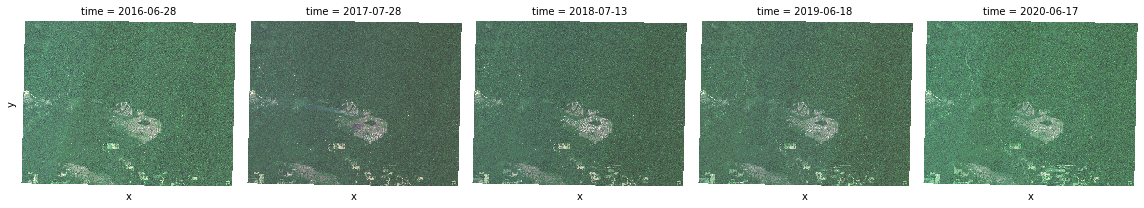

In [7]:
true_color_aggs = [
    ms.true_color(x.sel(band="red"), x.sel(band="green"), x.sel(band="blue"))
    for x in data
]

true_color = xr.concat(true_color_aggs, dim=data.coords["time"])

# visualize
t = true_color.plot.imshow(x="x", y="y", col="time", col_wrap=5)

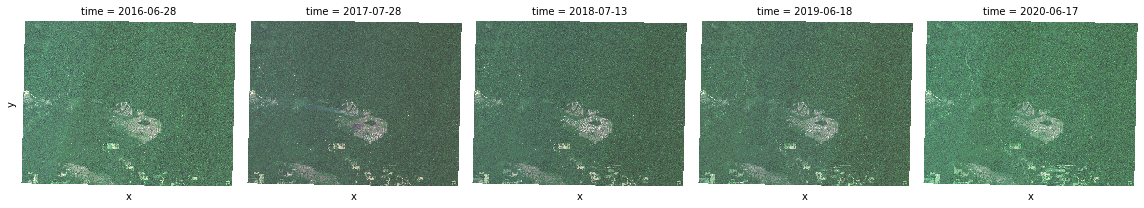

In [8]:
true_color_aggs = [
    ms.true_color(x.sel(band="red"), x.sel(band="green"), x.sel(band="blue"))
    for x in data
]

true_color = xr.concat(true_color_aggs, dim=data.coords["time"])

# visualize
t = true_color.plot.imshow(x="x", y="y", col="time", col_wrap=5)

### NDVI

NDVI can be calculated with [xarray-spatial](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.ndvi.html). We'll compute the NDVI for each year's image.

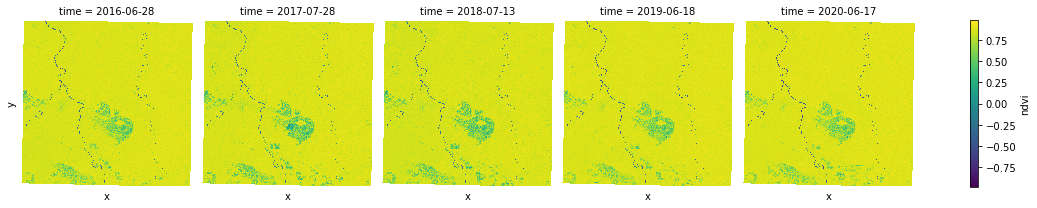

In [9]:
ndvi_aggs = [ms.ndvi(x.sel(band="nir"), x.sel(band="red")) for x in data]

ndvi = xr.concat(ndvi_aggs, dim="time")

ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis");

### Smoothing Images with Focal Mean

[`focal.mean`](https://xarray-spatial.org/reference/_autosummary/xrspatial.focal.mean.html) can be used to smooth or reduce noises in an image by a mean reduction to each 3x3 window in an image.

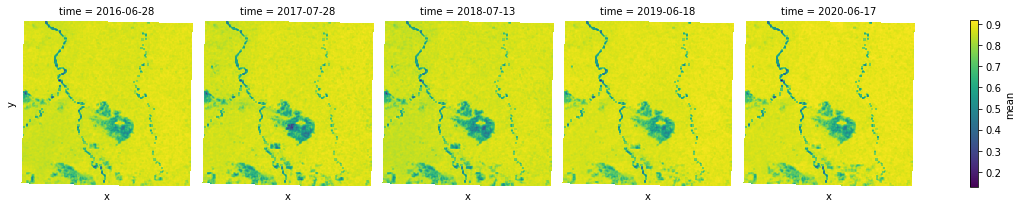

In [10]:
mean_aggs = [mean(ndvi_agg) for ndvi_agg in ndvi_aggs]

smooth = xr.concat(mean_aggs, dim="time")

s = smooth.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis")

### Focal statistics

In this step, we calculate [focal statistics](https://xarray-spatial.org/user_guide/focal.html#) using a circular kernel for the NDVI data arrays computed above. By default, seven statistics are computed:

1. Mean
2. Max
3. Min
4. Range
5. Std
6. Var
7. Sum

The result of `focal_stats` is a 3D `DataArray` with the newly added `stats` dimension.
The size of the kernel will affect the result of `focal_stats`. We'll use `cacl_cellsize` to determine a good kernel size. In this example, each pixel represents a region of `500m x 500m`, let's consider a circular kernel with a radius of 1.5km, equivalent to 3 times of the input cellsize.

In [11]:
cellsize = calc_cellsize(ndvi)
cellsize

(500.0, 500.0)

In [12]:
kernel = circle_kernel(*cellsize, radius=3 * cellsize[0])
kernel.shape

(7, 7)

In [13]:
%%time
stats_aggs = [focal_stats(ndvi_agg, kernel) for ndvi_agg in ndvi_aggs]

stats = xr.concat(stats_aggs, dim="time")

CPU times: user 379 ms, sys: 19.3 ms, total: 398 ms
Wall time: 385 ms


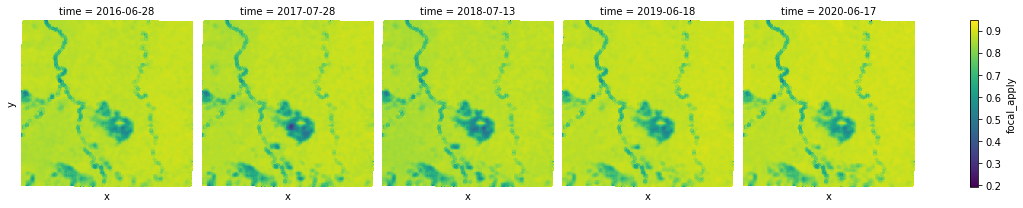

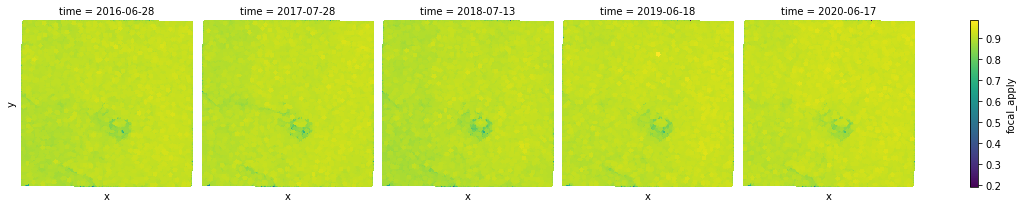

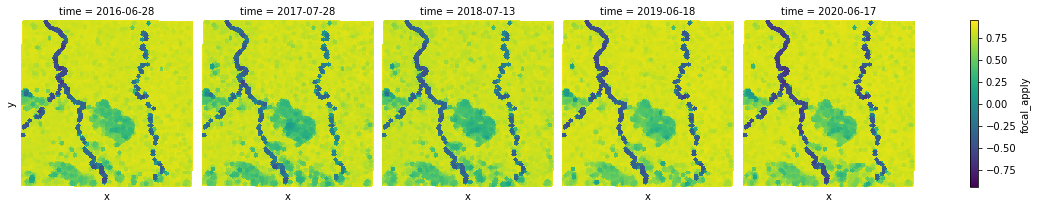

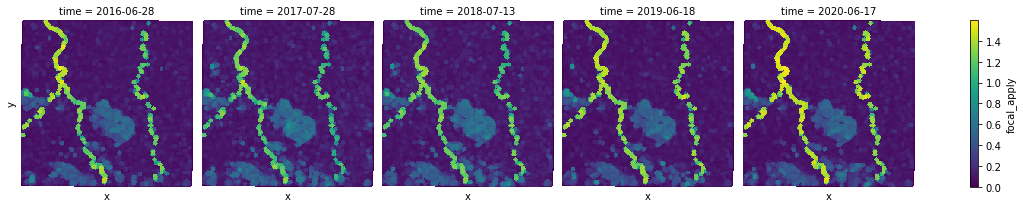

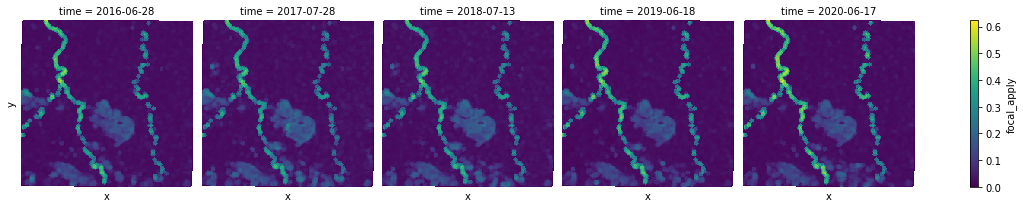

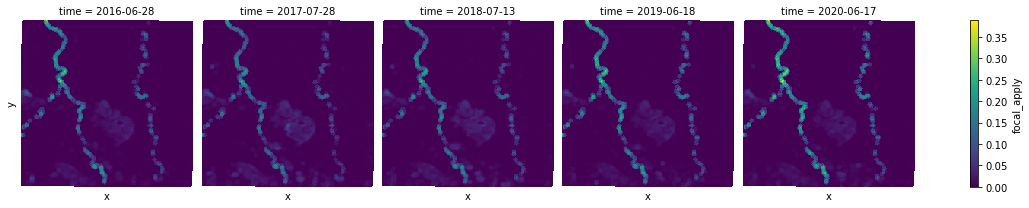

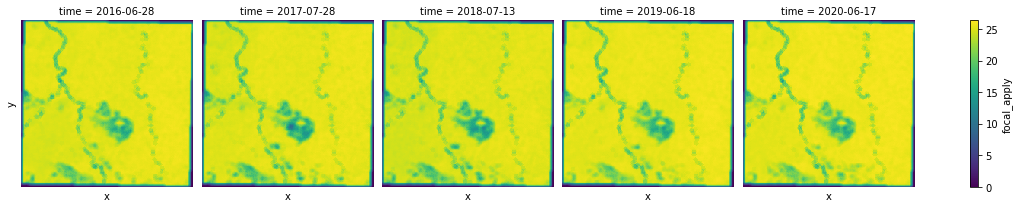

In [14]:
# transpose the data array so `stats` dimension appears first
stats_t = stats.transpose("stats", "time", "y", "x")

for stats_img in stats_t:
    g = stats_img.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis")

### Custom statistics

Sometimes you may want to a different statistic than the options provided in `focal_stats`, or you want to apply a custom kernel to your images. That's when you can think about using `convolution.convolution_2d` to calculate, for all inner cells of an array, the 2D convolution of each cell. Convolution is frequently used for image processing, such as smoothing, sharpening, and edge detection of images by eliminating spurious data or enhancing features in the data.

As an example, let's experiment a horizontal Sobel kernel.

In [15]:
# Use Sobel operator
sobel_kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

sobel_kernel

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

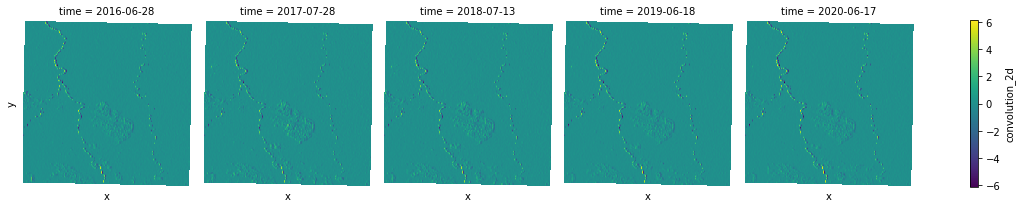

In [16]:
sobel_aggs = [convolution_2d(ndvi_agg, sobel_kernel) for ndvi_agg in ndvi_aggs]

sobel_agg = xr.concat(sobel_aggs, dim="time")

sobel_agg.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis");

### Hotspots
 
We can use the `hotspots` function to identify hot and cold spots in a DataArray. A statistically significant hot spot has a high value and is surrounded by other high values. A cold spot has a low value and is surrounded by other low values features.

Similar to other focal tools, to identify hot and cold spots we need to provide a kernel as a NumPy ndarary, along with the input data array to be analysed. The output array will have one of 7 possible values for each pixel of the input array:

- -99 for 99% confidence low value cluster (cold spot)
- -95 for 95% confidence low value cluster (cold spot)
- -90 for 90% confidence low value cluster (cold spot)
- 0 for no significance
- +90 for 90% confidence high value cluster (hot spot)
- +95 for 95% confidence high value cluster (hot spot)
- +99 for 99% confidence high value cluster (hot spot)

Hotspots are identified using z-scores of all cells in a input raster, which requires a global mean to be defined. Currently, `focal.hotspots` does not perform well in term of finding nan-mean of a Dask-backed data array, so let's use pure numpy-backed version for this.

In [17]:
%%time
hotspots_aggs = [hotspots(ndvi_agg, kernel) for ndvi_agg in ndvi]

hotspots_ndvi = xr.concat(hotspots_aggs, dim="time")

CPU times: user 114 ms, sys: 3.81 ms, total: 118 ms
Wall time: 112 ms


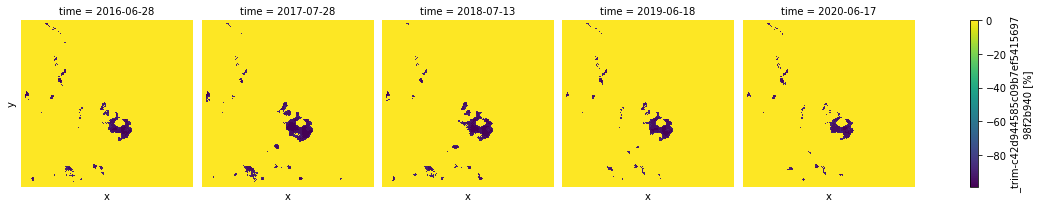

In [18]:
hotspots_ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis");

In [19]:
np.unique(hotspots_ndvi)

array([-99, -95, -90,   0], dtype=int8)

None of the results above are positive, so we can see that there only cold spots detected for this region. They expanded mostly from 2017 to 2018 and has been gradually recovered in 2020.

### Next steps

To find out more about xarray-spatial focal statistics and other toolsets provided by the library, please visit: https://xarray-spatial.org/index.html